# Rasterio and shipping 

## Introduction

### Overview
This notebook is a re-implementation of the chapter in the book *Python Maps*, relating to global shipping.  Being a chauvanistic Australian, I used shipping data for near Australia to re-imagine some of the  maps from the book 

### Data Source
 The data I used came from [https://datacatalog.worldbank.org/search/dataset/0037580]



The recommended citation is:

_“Data source: IMF’s World Seaborne Trade monitoring system (Cerdeiro, Komaromi, Liu and Saeed, 2020).”_

This is a very large dataset (over 9 Gigabytes), and this blog post is largely about how to handle very large rasters

-----------------------

## Implementation

### Notebook Magics

`watermark` provides reproducability data, `lab_black` enforces a standard Python style

In [1]:
%load_ext watermark

In [2]:
%load_ext lab_black

### Imports

All imports are here

In [3]:
import rasterio
import rasterio.plot as riop
import rasterio.mask as riom
from rasterio.enums import Resampling

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib

import pandas as pd
import geopandas as gpd
import shapely.geometry as sg

import cartopy.crs as ccrs
import cartopy

--------------------

## Data Load

Use rasterio to examine the properties of the dataset

In [4]:
URL = (
    "C:\\Data\\PythonMaps\\Shipping\\shipdensity_global.tif"
)

src = rasterio.open(URL)

Let us see how big the raster is - not small!

In [5]:
src.shape

(33998, 72006)

Look as the Coordinate Reference System

In [6]:
src.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

Examine the extent of the raster: almost the whole globe

In [7]:
src.bounds

BoundingBox(left=-180.015311275, bottom=-84.98735206299992, right=180.01468872500004, top=85.00264793700009)

Examine the band count (expect only 1, and not disappointed)

In [8]:
src.count

1

---------

## Downscaling with rasterio


The first approach we will take to to only take every 4-th pixel (in x and y direction).  We do this by specifying an `out_shape`  parameter on the `read`.  We don't need any fancy interpolation, so specify `nearest` for the resampling (using exact integer downscale factor, so this should never be an issue)

In [9]:
upscale_factor = 1.0 / 4

data = src.read(
    out_shape=(
        src.count,
        int(src.height * upscale_factor),
        int(src.width * upscale_factor),
    ),
    resampling=Resampling.nearest,
)

Examine raster size (as read from disk), indeed 1/4 size in X and Y direction

In [10]:
data.shape

(1, 8499, 18001)

### Initial visualization

Do a quick and easy plot.  I set up my own color map, to enhance the image.  The plot serves to give an overview of the major global shipping channels.

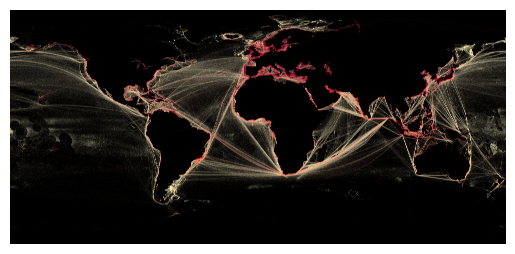

In [11]:
my_cmap = matplotlib.colormaps['YlOrRd']
my_cmap.set_bad(color='black')
my_cmap.set_under('black')


ax = plt.imshow(
    data[0], norm=colors.LogNorm(), cmap=my_cmap
)
ax.axes.set_axis_off()

Another view of my color map

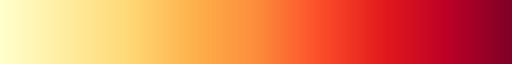

In [12]:
my_cmap

------------------

## Downsizing by masking

I decided to zoom into the shipping channels around Australia, and to the North.  I used the `rasterio` capability to read and mask in a specific area.

My specification of the area is a little complex

* Create a bounding box in Latitude / Longitude, as a `shapely` Polygon
* Create a GeoPandas GeoDataFrame with the polygon as the geometry of the only row
* Use Shapely to turn this geometry into a (single member) list of  GeoJSON specifications
* Use the `rastertio` `mask` operation to crop the large raster to the area we want

Set up bounding box polygon

In [13]:
latmin = -45
latmax = 20
lonmin = 100
lonmax = 155

oz = sg.Polygon(
    (
        (lonmin, latmin),
        (lonmax, latmin),
        (lonmax, latmax),
        (lonmin, latmax),
        (lonmin, latmin),
    )
)

Create GeoDataFrame with a polygon (really a box), and plot it to check

In [14]:
oz_box = gpd.GeoDataFrame(geometry=[oz])

<Axes: >

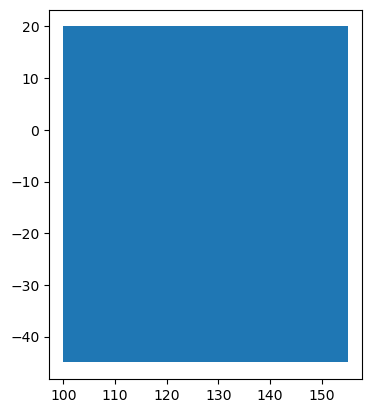

In [15]:
oz_box.plot()

Show the cropping box specification (could be boxes, but we have only one)

In [16]:
[sg.mapping(g) for g in oz_box.geometry.tolist()]

[{'type': 'Polygon',
  'coordinates': (((100.0, -45.0),
    (155.0, -45.0),
    (155.0, 20.0),
    (100.0, 20.0),
    (100.0, -45.0)),)}]

Perform the masking operation

In [17]:
clip_array, clip_trans = riom.mask(
    src,
    [sg.mapping(g) for g in oz_box.geometry.tolist()],
    crop=True,
    nodata=0,
)

Do a quick and easy plot

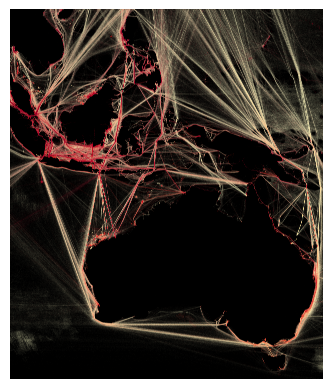

In [18]:
ax = plt.imshow(
    clip_array[0],
    norm=colors.LogNorm(),
    cmap=my_cmap,
)
ax.axes.set_axis_off()

-----------------------------------------

### Do detailed plot

We crank up Cartopy to do a more impressive image.  Interesting to see the shipping activity from Weipa (on Cape York),
and from the West Australia gas and iron ore ports.

What really jumps out at me is how important the Java Sea is to global and Australian trade!

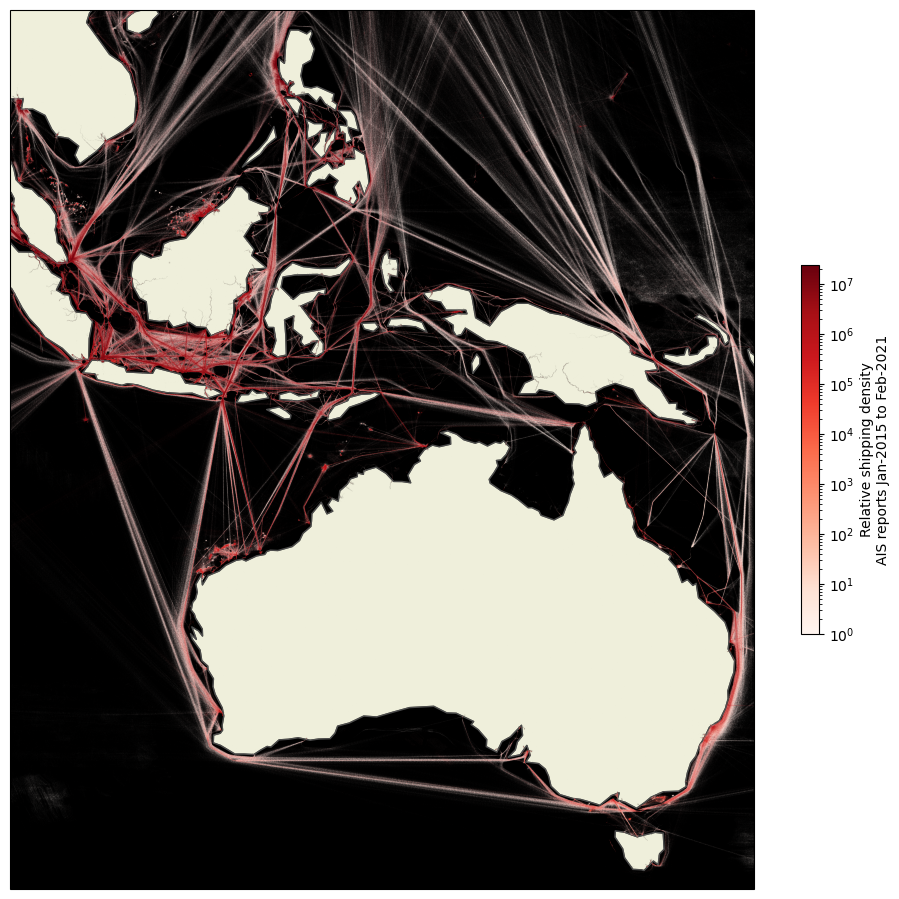

In [19]:
fig, ax = plt.subplots(
    figsize=(12, 12),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

# set background to black
ax.patch.set_facecolor('black')

# define the extent of the plot (Australia and waters to north)
ax.set_extent(
    [lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree()
)

# draw coastlines
ax.coastlines(
    resolution='110m',
    alpha=0.6,
    color='gray',
)

# add in land (default color)
ax.add_feature(
    cartopy.feature.LAND, zorder=0, edgecolor='black'
)

# plot the array of shipping density)
pcm = ax.imshow(
    clip_array[0],
    cmap='Reds',
    norm=colors.LogNorm(),
    extent=[lonmin, lonmax, latmin, latmax],
)

# create a colorbar
cb = fig.colorbar(
    pcm,
    ax=ax,
    shrink=0.4,
    orientation='vertical',
    label='Relative shipping density\nAIS reports Jan-2015 to Feb-2021',
)

## Reproducibility information

In [20]:
%watermark

Last updated: 2025-05-08T12:35:41.129829+10:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 170 Stepping 4, GenuineIntel
CPU cores   : 22
Architecture: 64bit



In [21]:
%watermark -co  -iv -v -h

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

conda environment: pythonmaps

Hostname: INSPIRON16

shapely   : 2.0.6
matplotlib: 3.10.0
pandas    : 2.2.3
geopandas : 1.0.1
cartopy   : 0.24.1
rasterio  : 1.4.3



-----------------------